#  <center> Baby Emotion Recognition <center>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow
from IPython.display import Audio
from tensorflow import keras 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
data = "DATA1.2 whithoutscared/"
paths=[]
labels=[]
for dirname,_,filenames in os.walk(data):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        label=filename.split('_')[0]
        #label=label.split('.')[0]
        labels.append(label.lower())
data_path=pd.DataFrame()
data_path['Emotions']=labels
data_path['Path']=paths
data_path

,Emotions,Path
0,angry,DATA1.2 whithoutscared/angry\angry_0.wav
1,angry,DATA1.2 whithoutscared/angry\angry_1.wav
2,angry,DATA1.2 whithoutscared/angry\angry_10.wav
3,angry,DATA1.2 whithoutscared/angry\angry_11.wav
4,angry,DATA1.2 whithoutscared/angry\angry_12.wav
...,...,...
438,sad,DATA1.2 whithoutscared/sad\sad_95.wav
439,sad,DATA1.2 whithoutscared/sad\sad_96.wav
440,sad,DATA1.2 whithoutscared/sad\sad_97.wav
441,sad,DATA1.2 whithoutscared/sad\sad_98.wav


## Data Visualisation and Exploration

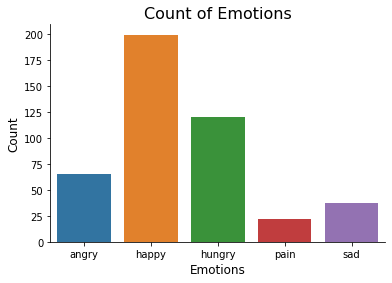

In [3]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

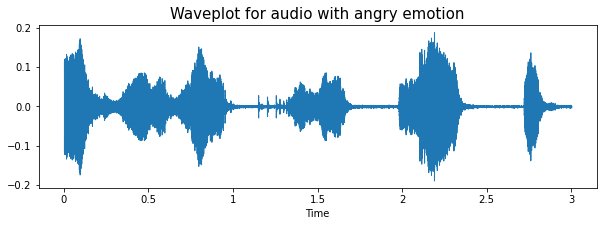

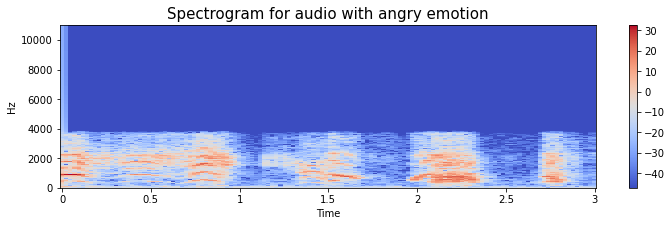

In [5]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

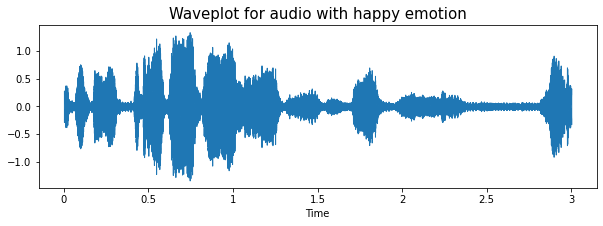

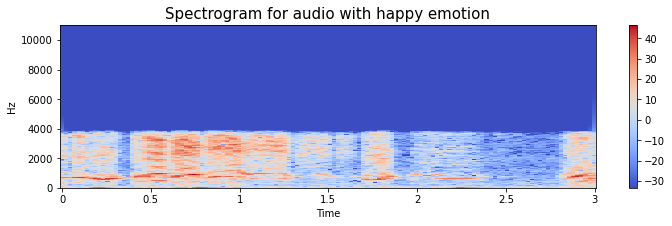

In [6]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

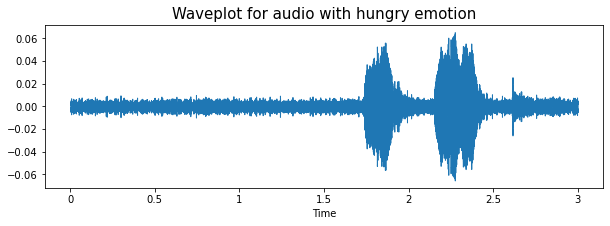

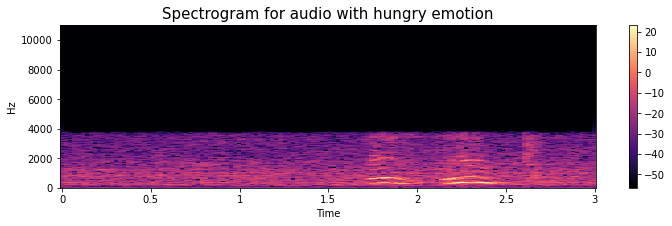

In [7]:
emotion='hungry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

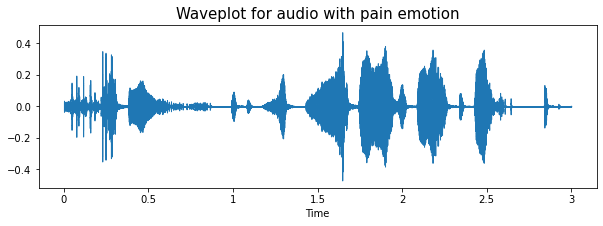

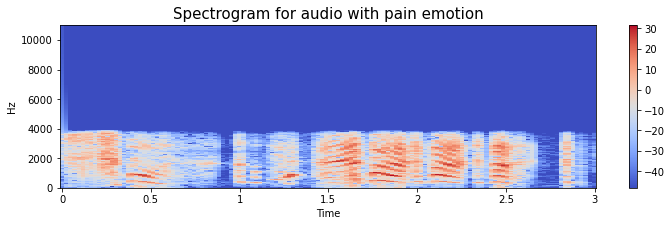

In [8]:
emotion='pain'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

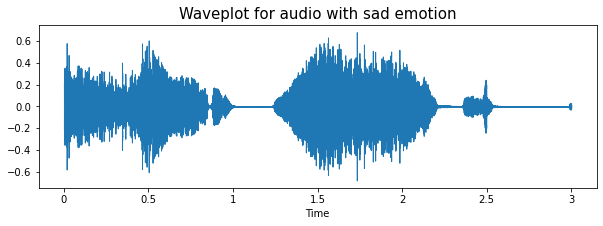

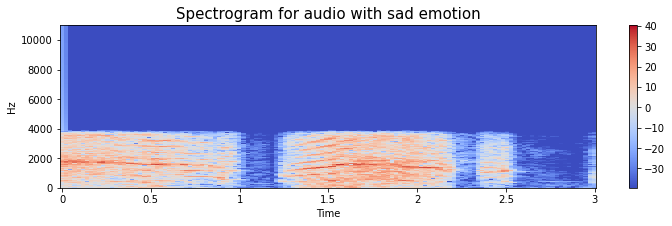

In [9]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmantaion

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

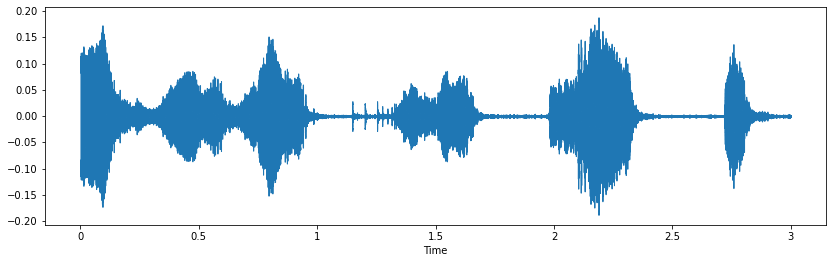

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

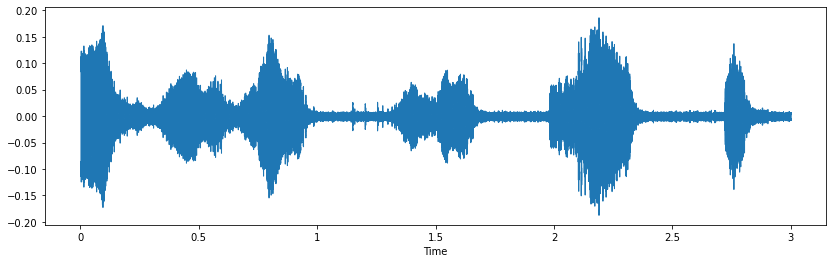

In [13]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

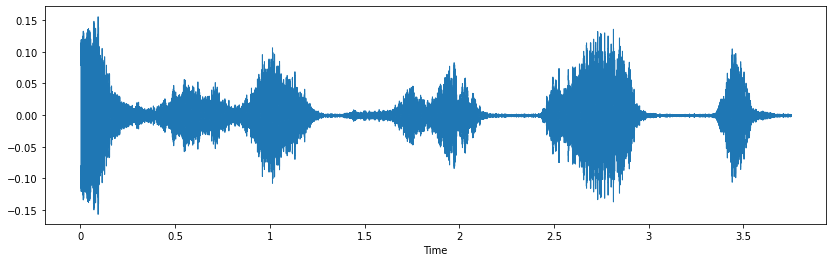

In [14]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

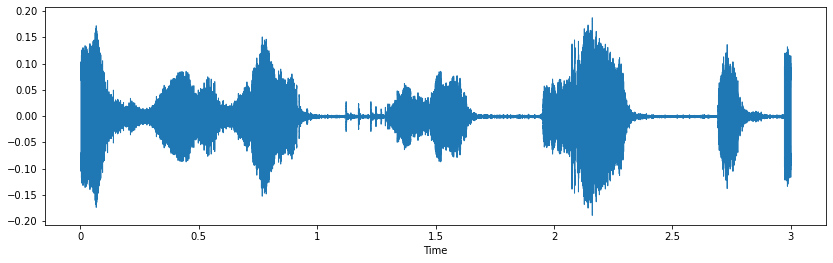

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

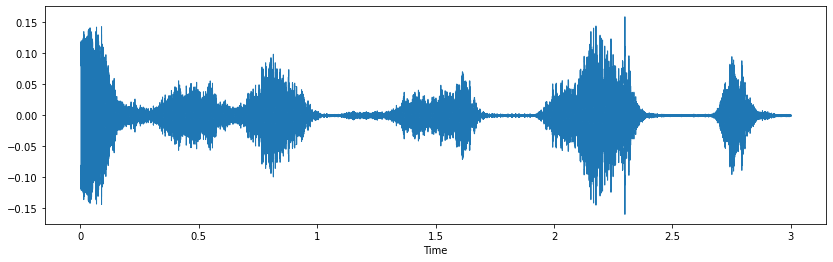

In [16]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In [12]:
def extract_features(data):
    # ZCR
    result = np.array([])
#     zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
#     result=np.hstack((result, zcr))
#     # Chroma_stft
#     stft = np.abs(librosa.stft(data))
#     chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

#     # Root Mean Square Value
#     rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#     result = np.hstack((result, rms))

#     # MelSpectogram
#     mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, mel))
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [7]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [8]:
len(X), len(Y), data_path.Path.shape

(1329, 1329, (443,))

In [10]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('saved information/features5lable.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-419.147278,167.210617,-80.646477,-5.268870,36.397373,-25.354713,-3.466598,12.055857,-6.444351,11.427505,...,-8.741704,6.514377,-1.125423,-5.228970,16.304382,9.069189,0.298773,11.031442,0.532193,angry
1,-257.768125,32.394898,-21.360948,-10.874330,7.819380,-3.768375,-7.940628,1.631102,4.513179,2.526456,...,0.993652,-1.156057,-2.822953,0.573059,7.758155,7.648087,4.703405,3.896409,0.520436,angry
2,-482.291443,170.378876,-93.207893,-1.139873,32.776711,-32.187325,0.189199,9.813438,-7.711108,13.864160,...,-8.984830,8.068591,-4.006941,1.493711,20.648558,4.388424,3.210703,9.995975,-6.776515,angry
3,-437.443298,179.078094,-80.799225,-7.174952,33.893093,-30.181896,-8.595564,8.615230,-3.189594,18.198673,...,-10.658390,10.815980,4.556132,-3.660127,12.594667,0.705870,-5.840614,11.743873,4.106140,angry
4,-307.890511,56.926948,-24.221742,-14.050983,7.583407,-8.642918,-12.951218,-0.763511,8.034029,8.843238,...,-0.446615,2.651305,3.132805,3.018117,4.913555,0.781641,-0.721716,5.782127,5.248442,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,-168.940861,124.824413,-47.949948,-9.964923,14.594936,-14.212861,8.716178,5.756896,-15.863287,6.521352,...,-6.609615,4.294111,-2.561980,-13.808906,3.250564,3.504590,-5.128624,2.420084,0.002273,sad
1325,-301.829742,199.737823,-99.152275,3.698066,24.740173,-32.943157,22.227249,4.256497,-25.364079,20.739347,...,-11.592039,12.361487,-11.187531,-11.806412,13.030143,-5.133560,-3.943139,7.525665,-7.173413,sad
1326,-268.476379,195.947861,-72.352959,10.578939,29.300932,-33.028992,14.507806,10.229531,-25.574154,12.497232,...,-15.839575,9.453563,-0.883971,-11.323150,11.670355,-1.091229,-8.210447,10.097579,-2.362915,sad
1327,-210.020594,126.533114,-33.481408,3.477343,16.138113,-17.003398,8.026875,5.322423,-15.804862,6.369190,...,-9.328174,4.010149,-0.664794,-6.927240,6.754357,0.191533,-5.396146,6.070093,-0.506170,sad


In [18]:
Features=pd.read_csv("features5lable.csv")
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.100257,0.582773,0.624451,0.564896,0.541182,0.568964,0.525788,0.615901,0.693984,0.704076,...,2.718364e-08,2.617227e-08,2.532415e-08,2.457941e-08,2.394295e-08,2.343311e-08,2.302327e-08,2.273837e-08,2.255133e-08,angry
1,0.213384,0.652420,0.699490,0.648341,0.630418,0.660913,0.566143,0.619549,0.688409,0.699479,...,1.812095e-04,1.723191e-04,1.698710e-04,1.782351e-04,1.863111e-04,1.810139e-04,1.905653e-04,1.873742e-04,1.763984e-04,angry
2,0.111061,0.486446,0.550656,0.620439,0.561136,0.516156,0.554317,0.469719,0.537361,0.680602,...,2.902446e-07,3.131978e-07,2.680815e-07,2.682029e-07,3.722521e-07,2.895913e-07,3.223929e-07,2.751373e-07,2.447462e-07,angry
3,0.090933,0.678766,0.647285,0.536712,0.475047,0.537874,0.612825,0.771314,0.827483,0.719632,...,3.222991e-10,3.122566e-10,3.038141e-10,2.963488e-10,2.899016e-10,2.847375e-10,2.805499e-10,2.776575e-10,2.757233e-10,angry
4,0.090708,0.679571,0.648254,0.537857,0.476236,0.538852,0.613117,0.771246,0.827440,0.719617,...,5.086519e-09,5.320162e-09,5.111599e-09,5.232947e-09,4.860382e-09,4.975912e-09,4.729967e-09,4.880992e-09,5.090060e-09,angry


## Data Preparation

In [11]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [12]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.1, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1196, 20), (1196, 5), (133, 20), (133, 5))

In [24]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1196, 20), (1196, 5), (133, 20), (133, 5))

In [25]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1196, 20, 1), (1196, 5), (133, 20, 1), (133, 5))

## Modelling

In [29]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 20, 256)           1536      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 10, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 10, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 5, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 5, 128)            163968    
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 3, 128)          

In [30]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0.2, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=5, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
240/240 [==============================] - 5s 16ms/step - loss: 1.3909 - accuracy: 0.4156 - val_loss: 1.2880 - val_accuracy: 0.4812 - lr: 0.0010
Epoch 2/50
240/240 [==============================] - 3s 11ms/step - loss: 1.2622 - accuracy: 0.4749 - val_loss: 1.2321 - val_accuracy: 0.4812 - lr: 0.0010
Epoch 3/50
240/240 [==============================] - 4s 15ms/step - loss: 1.1181 - accuracy: 0.5560 - val_loss: 1.2173 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 4/50
240/240 [==============================] - 4s 16ms/step - loss: 1.0921 - accuracy: 0.5652 - val_loss: 1.0375 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/50
240/240 [==============================] - 4s 16ms/step - loss: 0.9508 - accuracy: 0.6145 - val_loss: 1.0791 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 6/50
240/240 [==============================] - 4s 16ms/step - loss: 0.8724 - accuracy: 0.6421 - val_loss: 0.8740 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 7/50
240/240 [==============================] - 4s 16ms/st

5/5 [==============================] - 0s 10ms/step - loss: 0.7252 - accuracy: 0.8722
Accuracy of our model on test data :  87.21804618835449 %


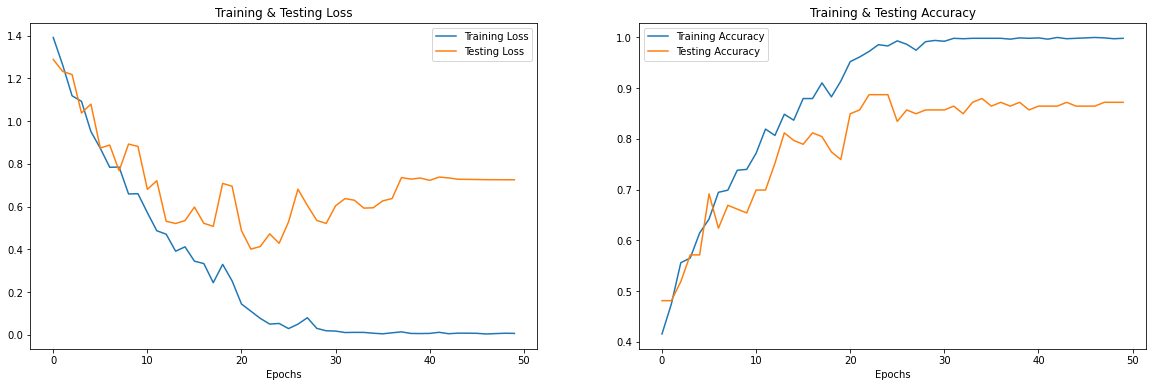

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [40]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

5/5 [==============================] - 0s 8ms/step


In [41]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,happy,happy
2,happy,happy
3,happy,happy
4,sad,sad
5,angry,angry
6,hungry,happy
7,happy,happy
8,happy,happy
9,happy,happy


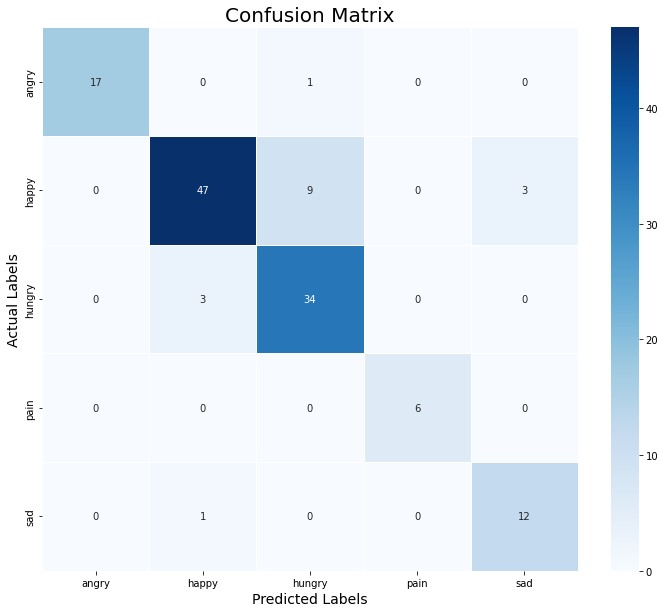

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      0.94      0.97        18
       happy       0.92      0.80      0.85        59
      hungry       0.77      0.92      0.84        37
        pain       1.00      1.00      1.00         6
         sad       0.80      0.92      0.86        13

    accuracy                           0.87       133
   macro avg       0.90      0.92      0.90       133
weighted avg       0.88      0.87      0.87       133



## LSTM

In [36]:
model1=Sequential([
    LSTM(123,return_sequences=False,input_shape=(x_train.shape[1], x_train.shape[2],)),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 123)               61500     
                                                                 
 dense_11 (Dense)            (None, 64)                7936      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                 165       
                                                                 
Total params: 71,681
Trainable params: 71,681
Non-trai

In [37]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=0, patience=2, min_lr=0.0000001)
history1=model1.fit(x_train, y_train, batch_size=5, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
240/240 [==============================] - 5s 11ms/step - loss: 1.3154 - accuracy: 0.4373 - val_loss: 1.1379 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 2/50
240/240 [==============================] - 2s 8ms/step - loss: 1.1363 - accuracy: 0.5217 - val_loss: 1.1186 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 3/50
240/240 [==============================] - 2s 9ms/step - loss: 1.0788 - accuracy: 0.5493 - val_loss: 1.0215 - val_accuracy: 0.5338 - lr: 0.0010
Epoch 4/50
240/240 [==============================] - 3s 12ms/step - loss: 1.0065 - accuracy: 0.5853 - val_loss: 1.0201 - val_accuracy: 0.5639 - lr: 0.0010
Epoch 5/50
240/240 [==============================] - 2s 8ms/step - loss: 0.9868 - accuracy: 0.5811 - val_loss: 1.1517 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 6/50
240/240 [==============================] - 3s 14ms/step - loss: 0.9712 - accuracy: 0.6062 - val_loss: 0.9667 - val_accuracy: 0.6015 - lr: 0.0010
Epoch 7/50
240/240 [==============================] - 2s 9ms/step -

5/5 [==============================] - 0s 10ms/step - loss: 0.7252 - accuracy: 0.8722
Accuracy of our model on test data :  87.21804618835449 %


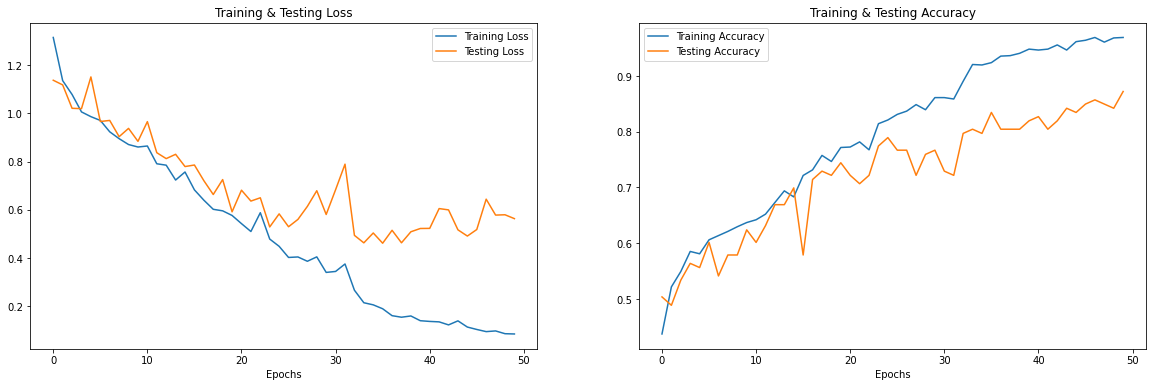

In [38]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
test_acc = history1.history['val_accuracy']
test_loss = history1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()